/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator


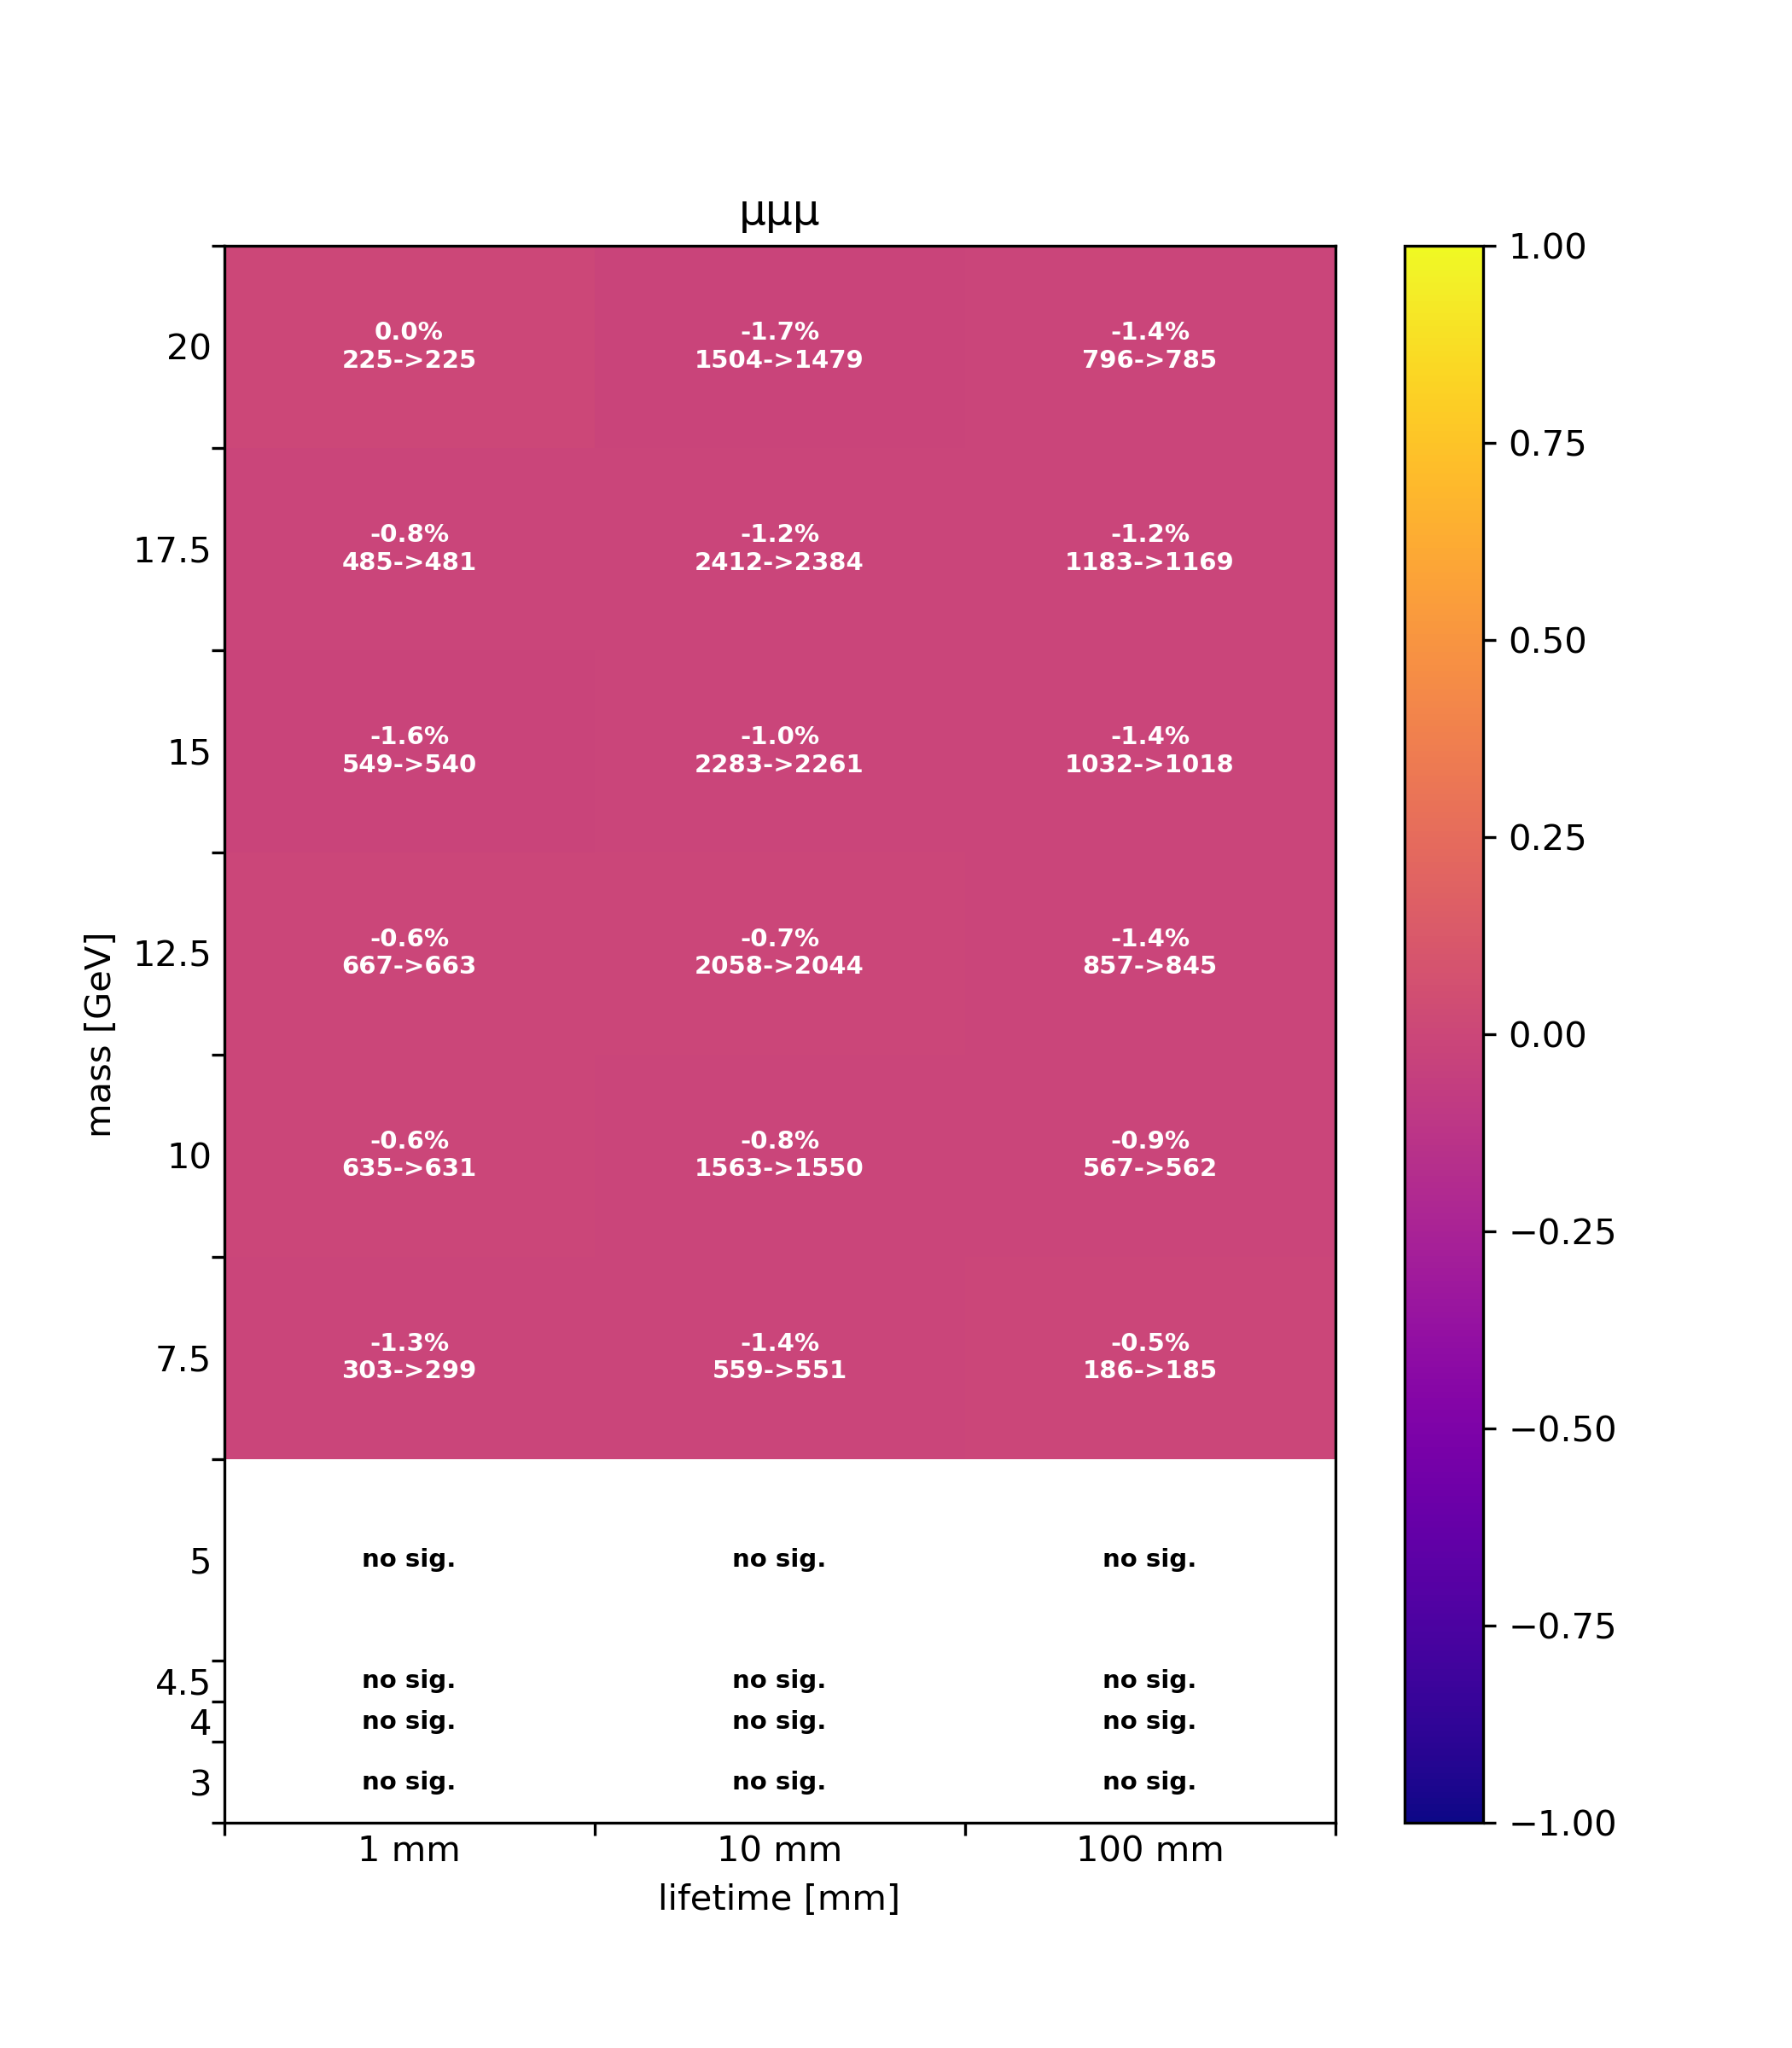

/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator


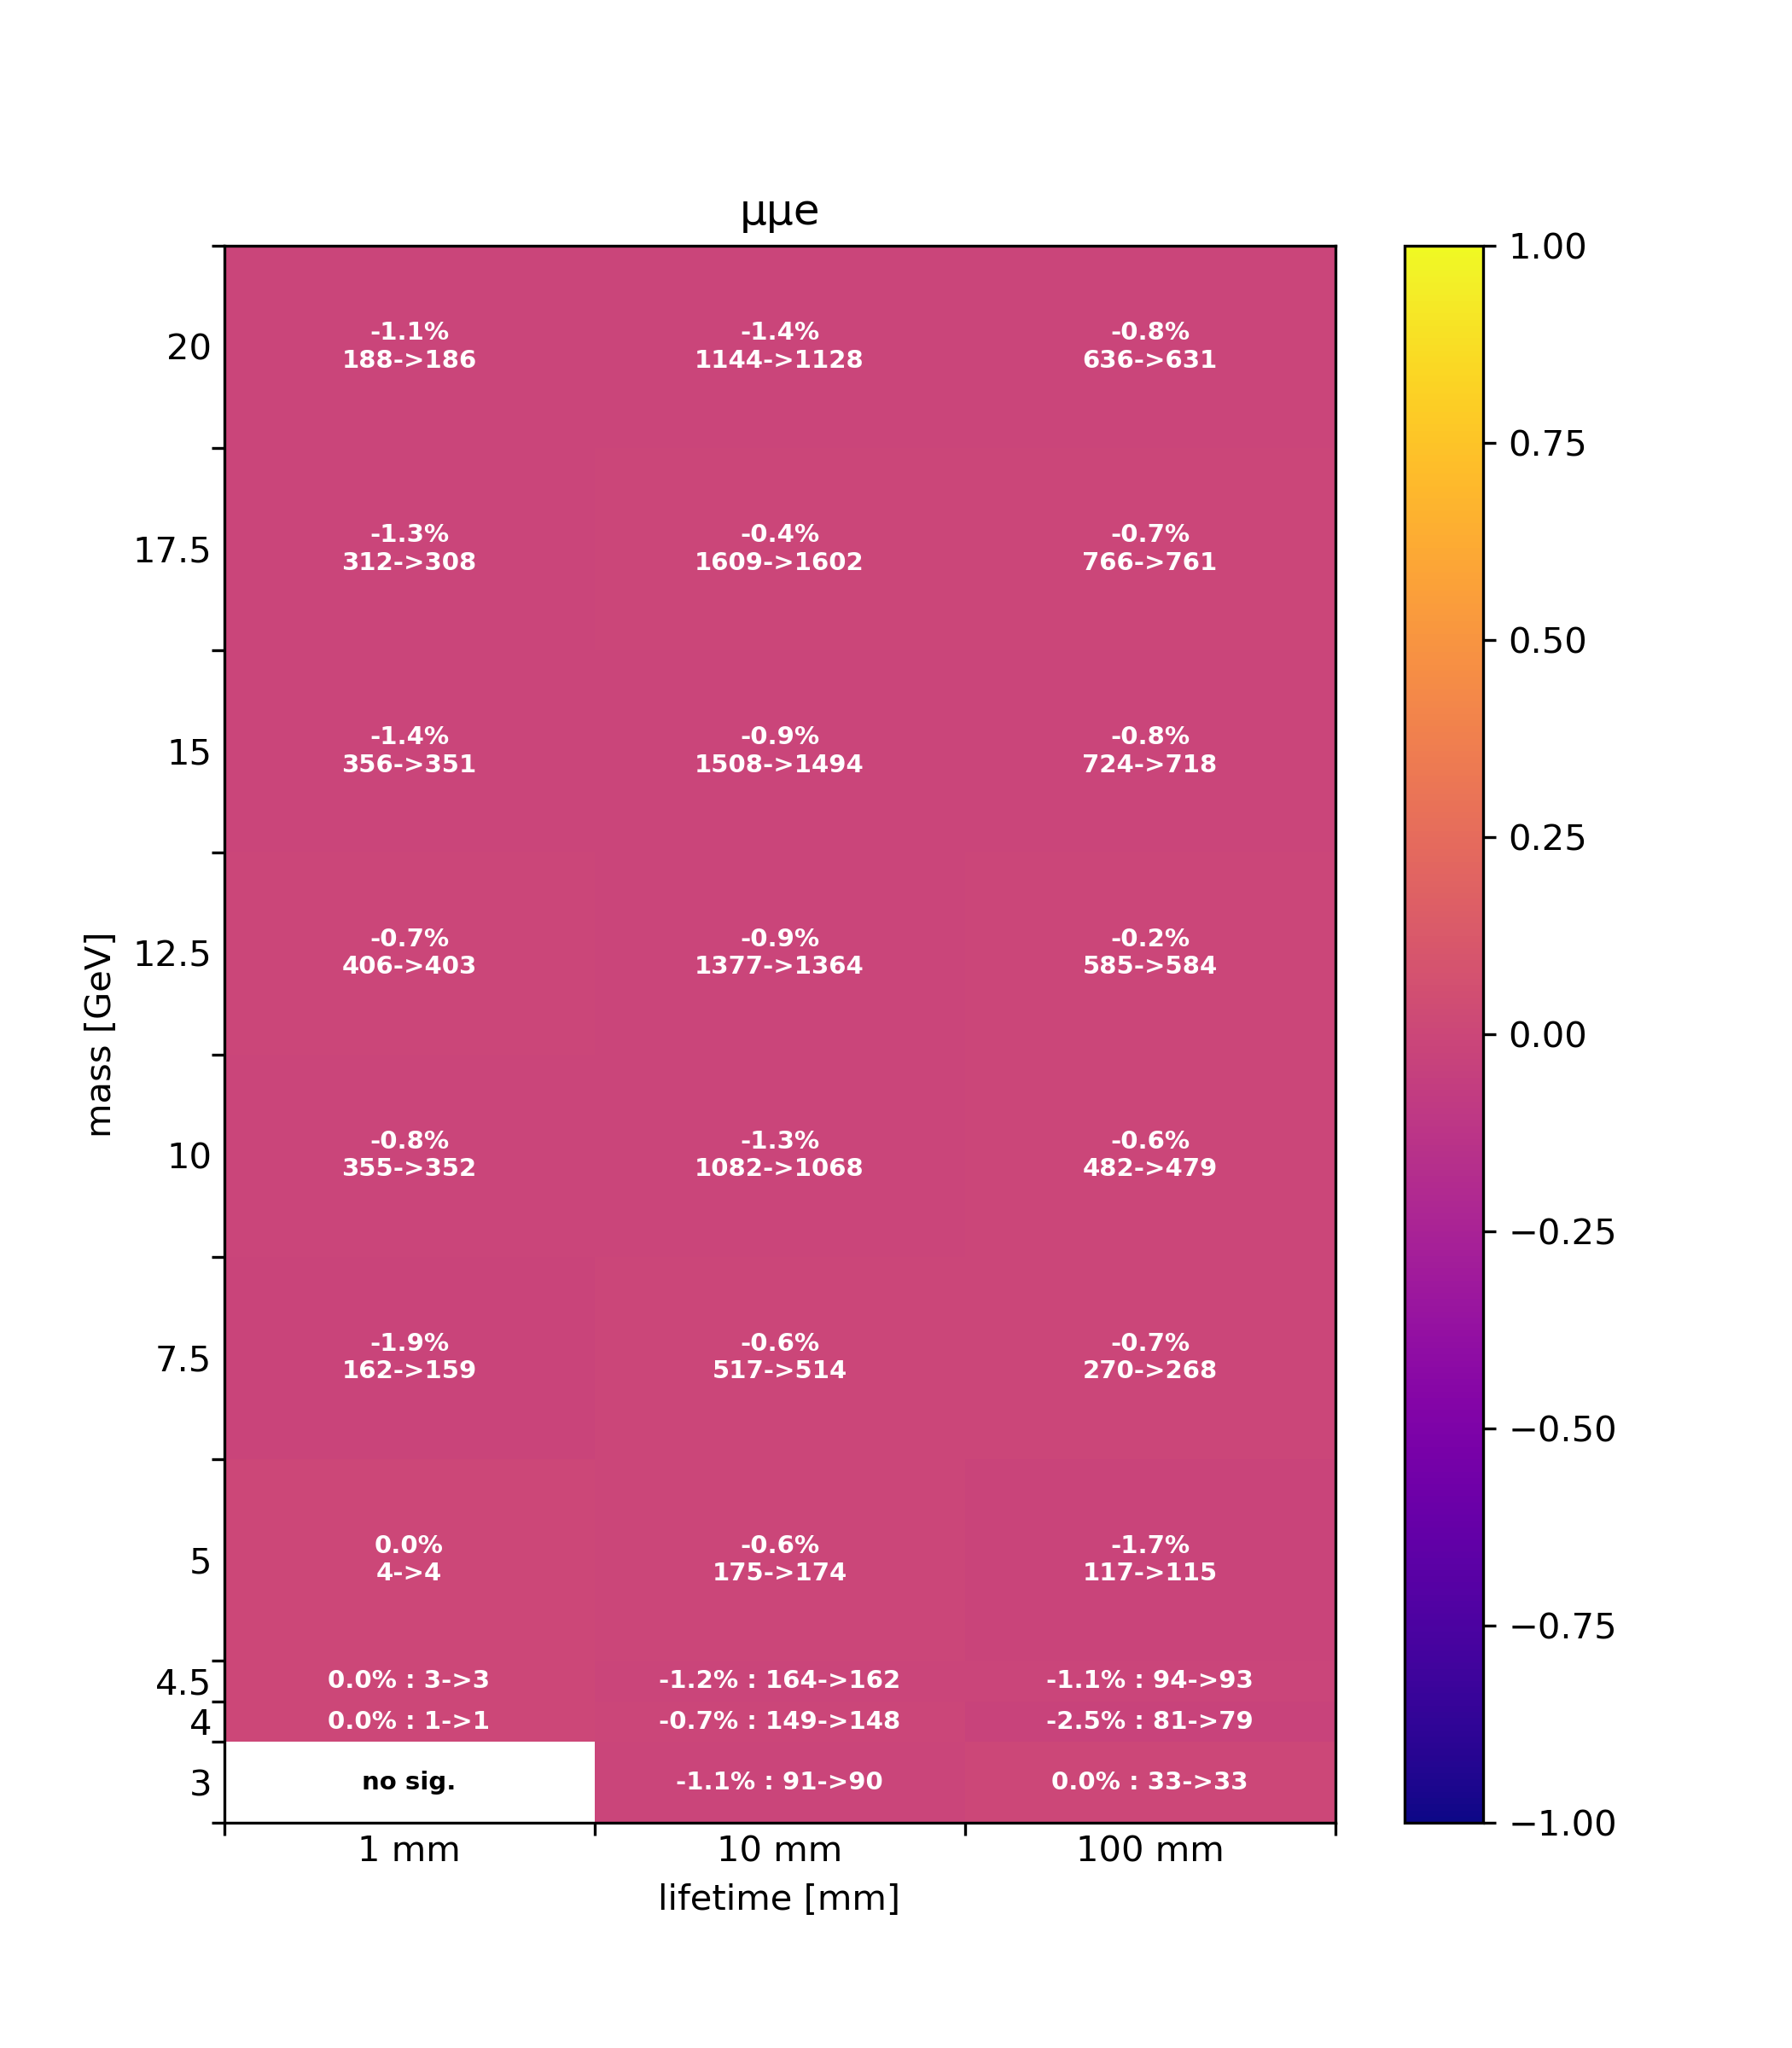

/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator


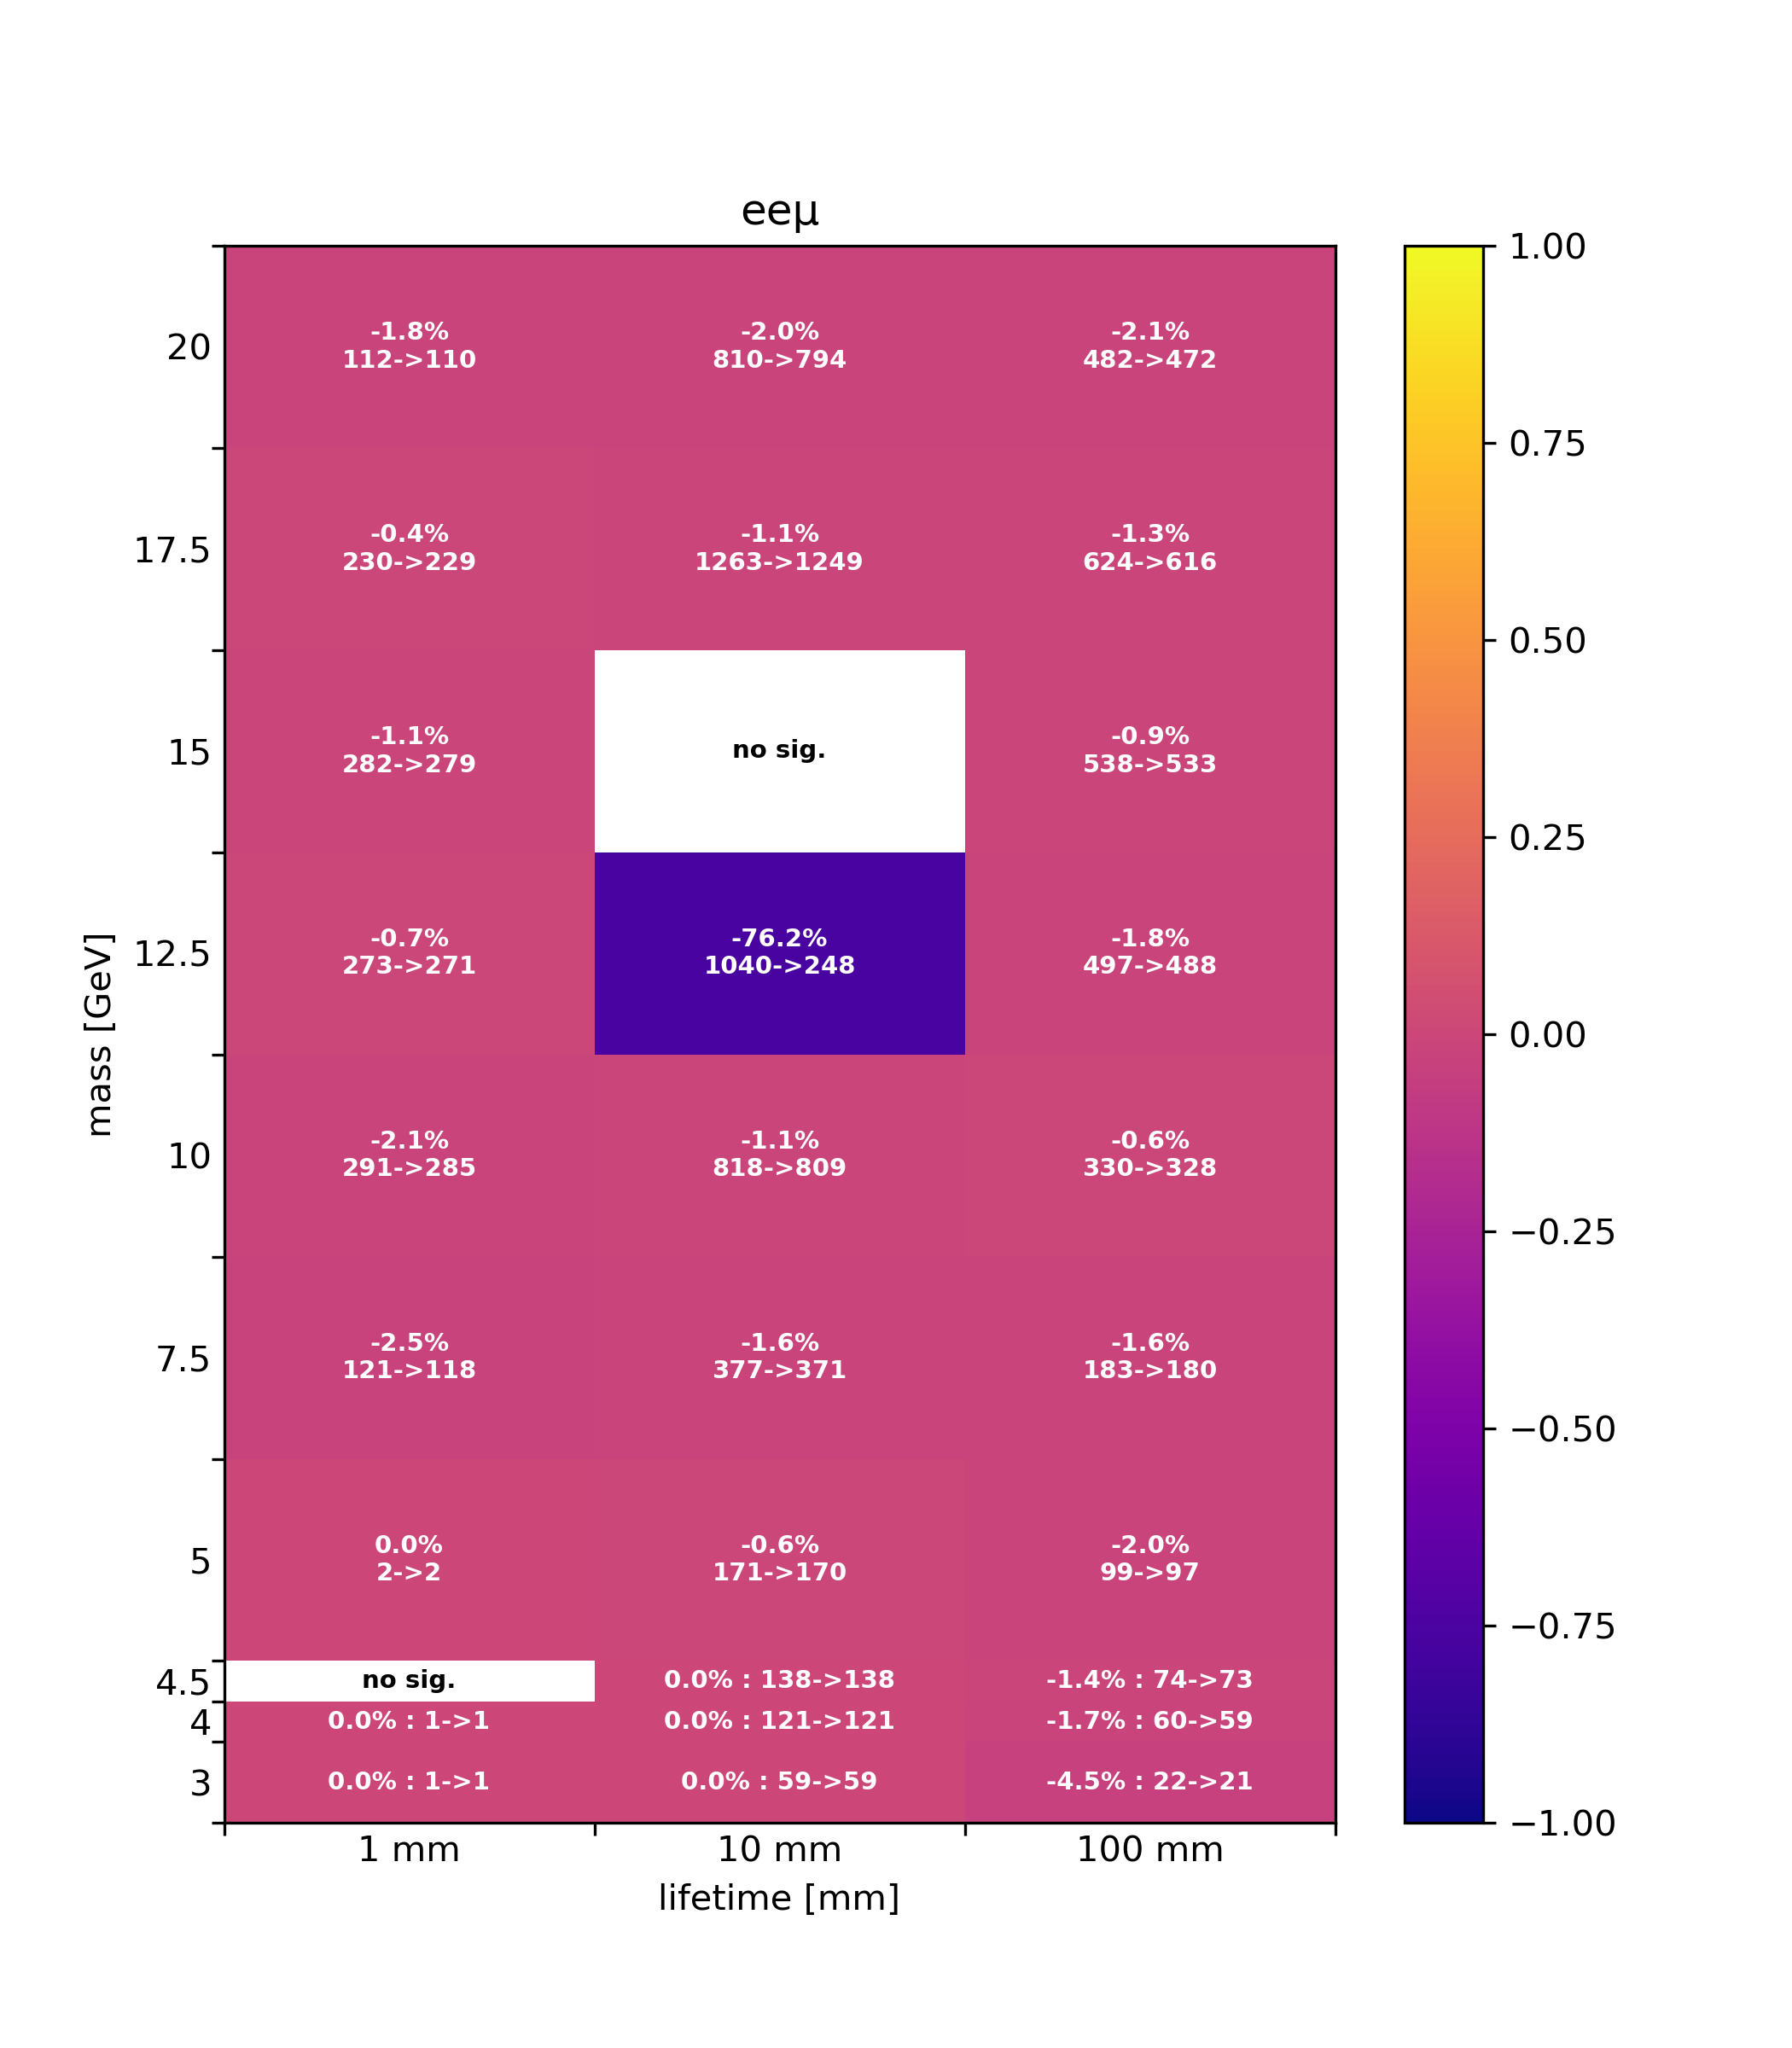

/home/newhouse/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator


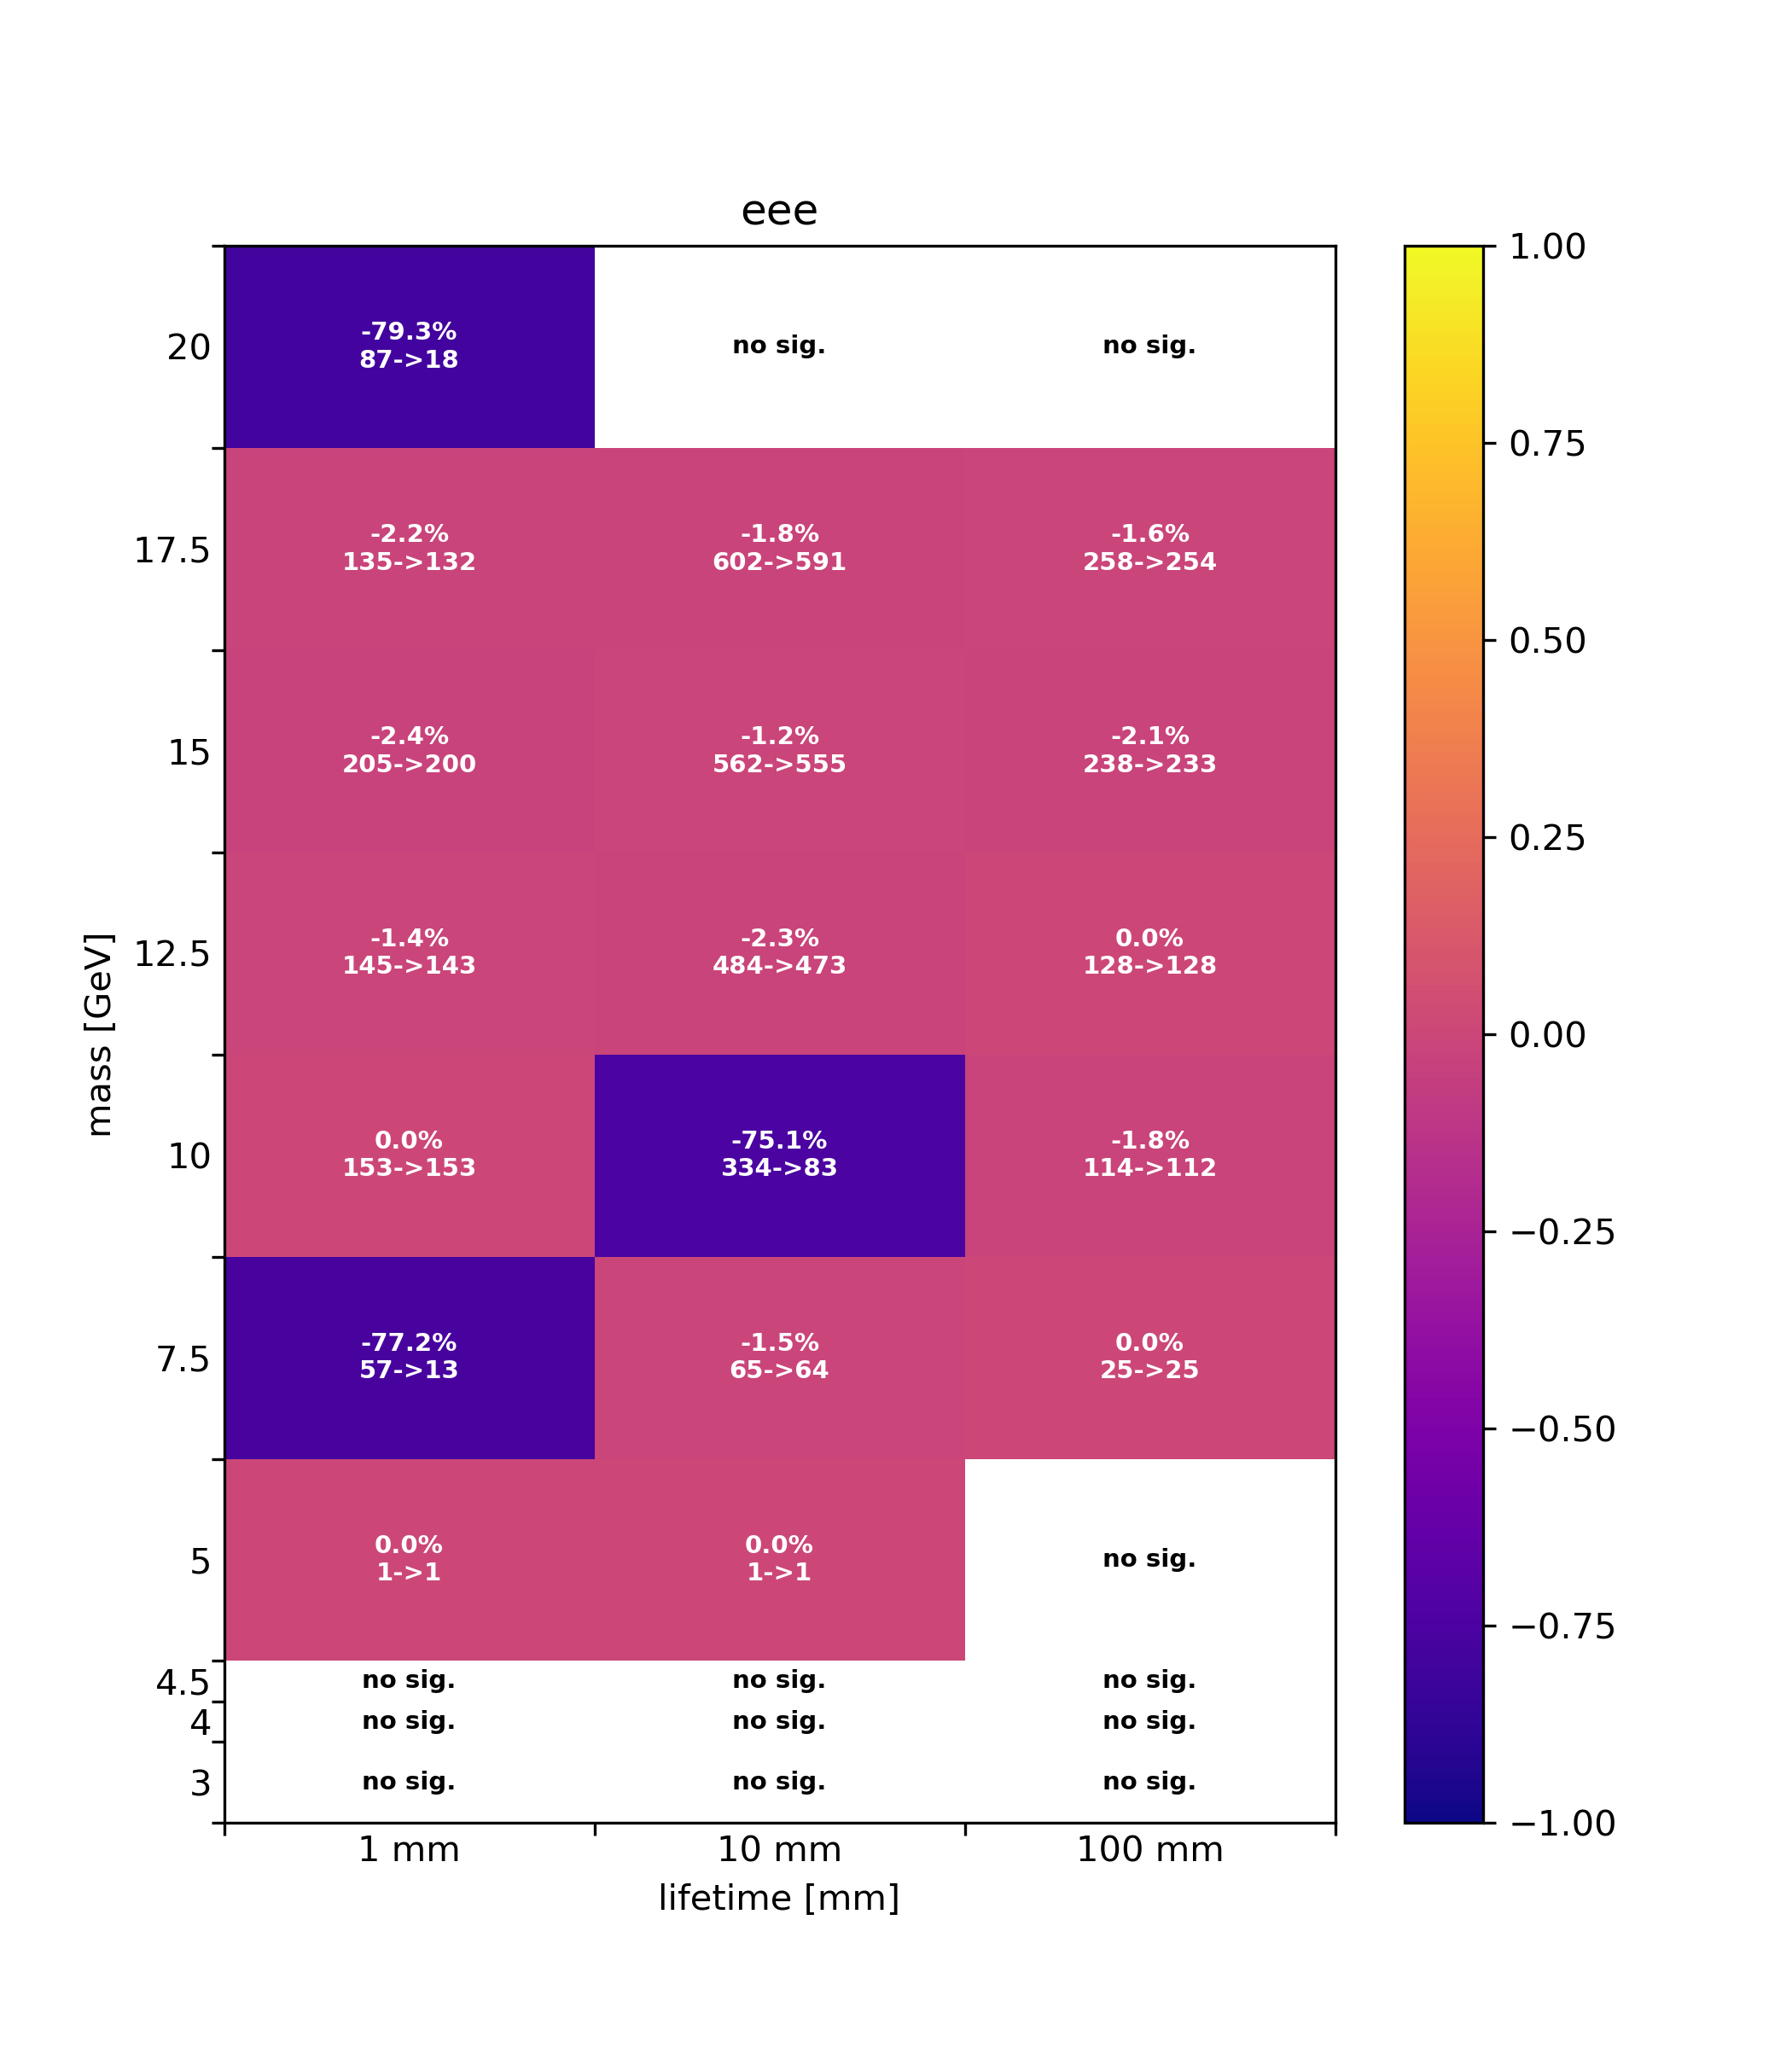

In [2]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image


masses = [3, 4, 4.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5]
lifetimes = {1:0, 10:1, 100:2}

text_options = {
    'ha' : 'center',
    'va' : 'center',
    'fontweight' : 'bold',
    'fontsize': 7,
}

def set_bin_content(mass, lifetime, value, arr):
    ybin = np.max(np.digitize(mass, masses)-1, 0)
    xbin = lifetimes[lifetime]
    arr[ybin,xbin] = value

def make_uncertainty_plot(histpath, title, outfile):

    count_arr = np.array([
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    [ 0.0,0.0,0.0,],
    ])

    count_arr_1 = np.array(count_arr)
    count_arr_2 = np.array(count_arr)
    diff_arr = np.array(count_arr)

    # get bins from ntuples    
    for hist_file in glob.glob(f'{indir_1}{histpath}'):
        try:
            f_fullrun2_1 = uproot.open(hist_file)
            f_fullrun2_2 = uproot.open(hist_file.replace(indir_1, indir_2))
        except:
            continue

        count_1 = -100
        count_2 = -100
        try:
            if weighted: count_1 = f_fullrun2_1['VSI_LeptonsMod/CutFlow/CutFlow_weighted_LNC'].pandas()[1:-1].iloc[-3]['count']
            else: count_1 = len(f_fullrun2_1['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['HNLm'])
        except: pass
        try:
            if weighted: count_2 = f_fullrun2_2['VSI_LeptonsMod/CutFlow/CutFlow_weighted_LNC'].pandas()[1:-1].iloc[-3]['count']
            else: count_2 = len(f_fullrun2_2['VSI_LeptonsMod_ntuples_LNC_plus_LNV_mHNL']['HNLm'])
        except: pass

        tokens = hist_file.split('histograms_fullrun2_')[1].split('_')
        file_mass = float(tokens[0][:-1].replace('p','.'))
        file_lifetime = int(tokens[1].split('mm')[0])

        set_bin_content(file_mass, file_lifetime, count_1, count_arr_1)
        set_bin_content(file_mass, file_lifetime, count_2, count_arr_2)

        diff = np.nan
        if count_2 >= 0:
            diff = (count_2-count_1)/count_1
        set_bin_content(file_mass, file_lifetime, diff, diff_arr)

    # do the plotting
    plot_uncertainties(count_arr_1, count_arr_2, diff_arr, title, outfile)
    return count_arr_1, count_arr_2, diff_arr

def plot_uncertainties(count_arr_1, count_arr_2, diff_arr, title, outfile):
    plt.figure(figsize=[7,8])
    plt.pcolormesh([0,1,2,3], masses, diff_arr, vmin=-.1, vmax=.1, cmap='plasma') # <<<<<<<<<<<<
    plt.colorbar()
    ax = plt.gca()

    # mess with x ticks
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels('')
    ax.set_xticklabels(['1 mm', '10 mm', '100 mm',], minor=True)
    ax.set_xticks([0.5,1.5,2.5,], minor=True)
    ax.tick_params(axis='both', which='minor', length=0)

    # mess with y ticks
    ax.set_yticks(masses)
    ax.set_yticklabels('')
    ax.tick_params(which='minor', length=0)
    ax.set_yticks(masses[:-1] + np.diff(masses)/2, minor=True)
    ax.set_yticklabels(masses[:-1], minor=True)

    ax.set_title(title)
    ax.set_xlabel('lifetime [mm]')
    ax.set_ylabel('mass [GeV]')

    # set text
    for i in range(len(masses)-1):
        for j in range(len(lifetimes)):
            yloc = j+.5
            xloc = masses[i] + (masses[i+1]-masses[i])/2
            if not np.isnan(diff_arr[i,j]):
                delim = '\n' if masses[i] >= 5 else ' : '
                if weighted: text = f'{diff_arr[i,j]:0.1%}{delim}{count_arr_1[i,j]:0.3f}->{count_arr_2[i,j]:0.3f}' 
                else: text = f'{diff_arr[i,j]:0.1%}{delim}{count_arr_1[i,j]:0.0f}->{count_arr_2[i,j]:0.0f}' 
                ax.text(yloc, xloc , text, color='white', transform=ax.transData, **text_options)
            else:
                text = 'no sig.'
                ax.text(yloc, xloc , text, color="black", transform=ax.transData, **text_options)

    os.makedirs(outdir, exist_ok=True)
    plt.savefig(outdir+outfile+'.png', dpi=300)
    plt.savefig(outdir+outfile+'.pdf', dpi=300)

weighted = False
indir_1 = '/data/hnl/histograms/v6p0_histograms/'
indir_2 = '/data/hnl/histograms/v6p1_histograms/'
outdir = '/home/newhouse/public/Analysis/HNL/dhnlanalysisnotebooks/ntuple_comparison/plots/'

make_uncertainty_plot(histpath=f'histograms_fullrun2_*_uuu.root', title='μμμ', outfile='compare_uuu')
display(Image(filename=f'{outdir}compare_uuu.png'));

make_uncertainty_plot(histpath='histograms_fullrun2_*_uue.root', title='μμe', outfile='compare_uue')
display(Image(filename=f'{outdir}compare_uue.png'));

make_uncertainty_plot(histpath='histograms_fullrun2_*_eeu.root', title='eeμ', outfile='compare_eeu')
display(Image(filename=f'{outdir}compare_eeu.png'));

make_uncertainty_plot(histpath='histograms_fullrun2_*_eee.root', title='eee', outfile='compare_eee')
display(Image(filename=f'{outdir}compare_eee.png'));
